<a href="https://colab.research.google.com/github/LNWork/Auslan-sign-app/blob/model/third_shingata_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from matplotlib import pyplot as plt
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import glob
import json
import time
import zipfile
from concurrent.futures import ProcessPoolExecutor, as_completed
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
SSD_PATH = '/content/gdrive/MyDrive/Auslan App/Data'

In [ ]:
%cd $SSD_PATH
%pwd

/content/gdrive/.shortcut-targets-by-id/1tK1wFii8GBHvsqqcHbnxGWpOkelsFvzD/Auslan App/Data


'/content/gdrive/.shortcut-targets-by-id/1tK1wFii8GBHvsqqcHbnxGWpOkelsFvzD/Auslan App/Data'

In [ ]:
import re
# test test test

def check_list_contained(A, B):
  # convert list A to string
    A_str = ' '.join(map(str, A))
    # convert list B to string
    B_str = ' '.join(map(str, B))
    # find all instances of A within B
    instances = re.findall(A_str, B_str)

    # return True if any instances were found, False otherwise
    return len(instances) > 0


In [ ]:
# !unzip -u json_keypoints_shaky.zip -d /jsonFolder

In [ ]:

def normalize_keypoints(data):
    normalized_data = []

    count = 0
    for sequence in data:
        if count % 500 == 0:
            print(count)
        count += 1
        if sequence.size == 0:
            # Handle empty sequences if necessary
            normalized_data.append(sequence)  # Or use np.zeros if you prefer
            continue

        coords = sequence[..., :3]  # Extract x, y, z coordinates
        # Min values across frames
        min_vals = np.min(coords, axis=(0, 1), keepdims=True)
        # Max values across frames
        max_vals = np.max(coords, axis=(0, 1), keepdims=True)

        # Normalize the coordinates
        normalized_coords = (coords - min_vals) / (max_vals - min_vals + 1e-8)

        # Create a new array for the normalized sequence
        normalized_sequence = sequence.copy()
        # Replace x, y, z with normalized values
        normalized_sequence[..., :3] = normalized_coords
        normalized_data.append(normalized_sequence)

    return normalized_data


def get_gloss_label(file_name, isosignsDF, singlewordDF):
    # Check if the file name starts with a digit to determine which DataFrame to use
    file_name = file_name.split("/")[-1]
    if 'video_64_147_1' in file_name or 'video_64_147_1_signer_keypoints' in file_name:
        return 'right'

    if file_name[0].isdigit():
        # Extract Video_ID from the filename
        video_id = file_name.split('_')[0]
        # Retrieve the row from the isosigns DataFrame based on Video_ID
        gloss_row = isosignsDF.loc[isosignsDF['Video_ID'] == int(video_id)]
    else:
        # Extract Video_Clip_Name from the filename
        video_clip_name = '_'.join(file_name.split('_')[:3])
        # Retrieve the row from the singleword DataFrame based on Video_Clip_Name
        gloss_row = singlewordDF.loc[singlewordDF['Video_Clip_Name']
                                     == video_clip_name]

    # Check if a match was found and return the Gloss value
    if not gloss_row.empty:
        # Note the capitalization of 'Gloss'
        return gloss_row['Gloss'].values[0]
    else:
        return None


def process_file(file):
    # print(f"Processing {file}")
    largestFrames = 0
    xData = []
    yData = []

    with open(file, 'r') as f:
        d = f.read()
        vidData = json.loads(d)

        data = []
        for frame in vidData:
            if 'data' not in frame.keys():
                continue

            fData = pd.DataFrame(frame['data'])
            data.append(fData)

        if len(data) == 0:
            return None, None, largestFrames

        combinedDF = pd.concat(data, ignore_index=True)
        reshapedData = combinedDF.values.reshape((len(data), 75, 4))
        largestFrames = max(largestFrames, len(data))

        word = get_gloss_label(file, isosignsDF, singlewordDF)

        # Handle missing gloss
        if word is None:
            print(f"Warning: No gloss label found for {file}")
            return None, None, largestFrames

        xData.append(reshapedData)
        yData.append(word)

    return xData, yData, largestFrames

def get_class_weights(y_train, num_classes):
  class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.arange(num_classes),
                                        y=y_train)  # No need for np.argmax since y_train is integer labels
  return dict(enumerate(class_weights))

In [ ]:
def get_class_weights(y_train, num_classes):
  class_weights = compute_class_weight(class_weight='balanced',
                                        classes=np.arange(num_classes),
                                        y=y_train)  # No need for np.argmax since y_train is integer labels
  return dict(enumerate(class_weights))

In [ ]:
# CHANGE HERE TO IMPORT OR SAVE
saved = True
if saved:
  data = np.load('reduced_normalized_data5.npz', allow_pickle=True)
  xData_padded = data['xData']
  # xData_padded = xData_padded.reshape((xData_padded.shape[0], xData_padded.shape[1], xData_padded.shape[2], 4, 1))
  y_mapped = data['yData']
  x_train, x_test, y_train, y_test = train_test_split(xData_padded, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42)
  num_classes = len(np.unique(y_train))
  class_weights = get_class_weights(y_train, num_classes)
  print(f"Class weights: {class_weights}")

else:
  # Load the DataFrames outside of the function
  isosignsDF = pd.read_excel('datasignlist.xlsx', sheet_name='IsoSigns', usecols="B:D")
  singlewordDF = pd.read_excel('datasignlist.xlsx', sheet_name='SingleWord', usecols="B:D")

  # Path to the folder containing the JSON files
  files = glob.glob('/jsonFolder/json_keypoints/*')
  count = 0

  xData = []
  yData = []
  largestFrames = 0

  start = time.time()
  count = 0

  # Create a ProcessPoolExecutor for parallel processing
  with ProcessPoolExecutor(max_workers=8) as executor:
    # Use a list comprehension to submit the processing of each file
    futures = {executor.submit(
        process_file, file_name): file_name for file_name in files}

    for future in futures:
        reshaped_data, label, maxFrames = future.result()
        if reshaped_data is not None and label is not None:
            # Extend instead of append to flatten the structure
            xData.extend(reshaped_data)
            yData.append(label)
            largestFrames = max(largestFrames, maxFrames)

        if count % 500 == 0:
            print(count)
            # print(time.time()-start)
        count += 1

    xData = np.array(xData, dtype=object)
    yData = np.array(yData, dtype=object)

    # x_train, x_test, y_train, y_test = train_test_split(
    #     xData, yData, test_size=0.2, stratify=yData, random_state=42)

    # print("Train samples:", len(x_train), "Test samples:", len(x_test))
    print("Largest frames:", largestFrames)
    print("Time taken:", time.time() - start)

    np.savez_compressed('processed_data.npz', xData=xData, yData=yData)
    max_length = 145
    data = np.load('processed_data.npz', allow_pickle=True)

    print(len(data['xData']))
    xData = data['xData']
    yData = data['yData']
    print(xData.shape, yData.shape)
    print(xData[0].shape)
    print(yData[1])
    print(yData[2222])
    print(f"Unique labels in yData: {np.unique(yData)}")
    print(f"Number of unique labels: {len(np.unique(yData))}")
    xData_normalized = normalize_keypoints(xData)

    # Convert each element of yData to a hashable type (e.g., string)
    yData_str = [str(label) if isinstance(label, np.ndarray)
                 else label for label in yData]

    print(len(yData_str))

    # Get unique classes
    # Ensure the labels are hashable
    unique_classes = sorted(list(set(yData_str)))
    print(unique_classes)

    # Create a mapping from label to class index
    label_to_class_index = {label: idx for idx,
                            label in enumerate(unique_classes)}
    print(len(label_to_class_index))

    # Map yData to class indices
    y_mapped = [label_to_class_index[label] for label in yData_str]
    print(f"Number of unique classes: {len(np.unique(y_mapped))}")

    xData_padded = pad_sequences(
        xData_normalized, maxlen=max_length, dtype='float32', padding='post', truncating='post')

    np.savez('normalized_data.npz',
             xData_padded=xData_padded, y_mapped=y_mapped)

    print(f"Number of unique classes: {len(unique_classes)}")
    x_train, x_test, y_train, y_test = train_test_split(xData_padded, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42)
    num_classes = len(np.unique(y_train))
    class_weights = get_class_weights(y_train, num_classes)
    print(f"Class weights: {class_weights}")

Class weights: {0: 1.0590325018896447, 1: 0.6354195011337869, 2: 1.3616132167152575, 3: 1.0590325018896447, 4: 1.121328531412565, 5: 0.9531292517006803, 6: 0.6354195011337869, 7: 1.3616132167152575, 8: 1.3616132167152575, 9: 1.121328531412565, 10: 1.1914115646258503, 11: 0.6573305184142623, 12: 0.7625034013605442, 13: 0.8664811379097094, 14: 0.9531292517006803, 15: 1.1914115646258503, 16: 0.7331763474620617, 17: 1.3616132167152575, 18: 0.9531292517006803, 19: 1.3616132167152575, 20: 0.7331763474620617, 21: 1.1914115646258503, 22: 0.9531292517006803, 23: 1.3616132167152575, 24: 0.7942743764172335, 25: 1.0590325018896447, 26: 1.0590325018896447, 27: 1.1914115646258503, 28: 0.6149220978714066, 29: 0.9077421444768383, 30: 0.7625034013605442, 31: 1.0590325018896447, 32: 1.0590325018896447, 33: 0.9531292517006803, 34: 2.723226433430515, 35: 1.2708390022675737, 36: 1.3616132167152575, 37: 0.7060216679264298, 38: 0.9531292517006803, 39: 1.0032939491586108, 40: 1.0032939491586108, 41: 0.8664811

In [ ]:
def create_model_conv3d_transformer(input_shape, num_classes, num_heads=8, ff_dim=64):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv3D to capture spatio-temporal features
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    print(x.shape)

    # Add another Conv3D layer
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    print(x.shape)

    # Pooling to reduce dimensionality
    x = GlobalAveragePooling3D()(x)  # Alternatively, you could use Flatten here
    print(x.shape)

    # Reshape for MultiHeadAttention
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # Use Lambda to apply expand_dims
    print(x.shape)

    # Transformer block (using MultiHeadAttention)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = Add()([x, attn_output])  # Residual connection
    attn_output = LayerNormalization()(attn_output)
    print(attn_output.shape)

    # Feed-forward block with residual connection
    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Add()([attn_output, ff_output])  # Residual connection
    ff_output = LayerNormalization()(ff_output)
    print(ff_output.shape)

    # Flatten the output before the dense layer for classification
    ff_output = Flatten()(ff_output)

    # Fully connected layer for classification
    x = Dense(128, activation='relu')(ff_output)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def data_generator(x_data, y_data, batch_size):
    num_samples = len(x_data)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = x_data[offset:offset+batch_size]
            batch_y = y_data[offset:offset+batch_size]
            yield batch_x, batch_y

batch_size = 32

# Create training and validation generators
train_generator = data_generator(x_train, y_train, batch_size)
test_generator = data_generator(x_test, y_test, batch_size)

In [ ]:
# Get the input shape based on your data
input_shape = (xData_padded.shape[1], xData_padded.shape[2], 4, 1)
print(input_shape)
# Create the GRU model
model = create_model_conv3d_transformer(input_shape, num_classes)

model_checkpoint = ModelCheckpoint(
    filepath = '/content/gdrive/MyDrive/Auslan App/Model/Checkpoints/shingata.keras',
    monitor = 'accuracy',
    save_best_only = True,
    verbose = 1
)
# Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# model.summary()
dummy_input = np.random.random((1, *input_shape))  # Dummy input with shape (1, 145, 75, 4, 1)
model(dummy_input)  # Call the model to build it

# Now call model.summary() to see the architecture
model.summary()

(145, 75, 4, 1)
(None, 145, 75, 4, 32)
(None, 145, 75, 4, 64)
(None, 64)
(None, 1, 64)
(None, 1, 64)
(None, 1, 64)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 145, 75, 4, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_14 (Conv3D)        │ (None, 145, 75, 4, 32) │            896 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 145, 75, 4, 32) │            128 │ conv3d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_15 (Conv3D)        │ (None, 145, 75, 4, 64) │         55,360 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 145, 75, 4, 64) │            256 │ conv3d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d… │ (None, 64)             │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 64)          │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_7    │ (None, 1, 64)          │        132,672 │ lambda_2[0][0],        │
│ (MultiHeadAttention)      │                        │                │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 1, 64)          │              0 │ lambda_2[0][0],        │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_10    │ (None, 1, 64)          │            128 │ add_14[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 1, 64)          │          4,160 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 1, 64)          │              0 │ layer_normalization_1… │
│                           │                        │                │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_11    │ (None, 1, 64)          │            128 │ add_15[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 128)            │          8,320 │ flatten_1[0][0]        │
├──────────────────────

 Total params: 296,863 (1.13 MB)

 Trainable params: 296,671 (1.13 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,  # Total steps per epoch
    validation_data=test_generator,
    validation_steps=len(x_test) // batch_size,  # Total steps for validation
    epochs=20,
    verbose=1,
    callbacks=[model_checkpoint]
)

Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5004 - loss: 1.8924
Epoch 1: accuracy improved from 0.48573 to 0.50318, saving model to /content/gdrive/MyDrive/Auslan App/Model/Checkpoints/shingata.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 101s 232ms/step - accuracy: 0.5004 - loss: 1.8924 - val_accuracy: 0.1965 - val_loss: 4.6794
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5184 - loss: 1.8283
Epoch 2: accuracy improved from 0.50318 to 0.52064, saving model to /content/gdrive/MyDrive/Auslan App/Model/Checkpoints/shingata.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 104s 238ms/step - accuracy: 0.5184 - loss: 1.8282 - val_accuracy: 0.2374 - val_loss: 4.4582
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5377 - loss: 1.7397
Epoch 3: accuracy improved from 0.52064 to 0.54010, saving model to /content/gdrive/MyDrive/Auslan App/Model/Checkpoints/shingata.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 105s 240ms/step - accuracy: 0.5377 - loss: 1.7396 - val_a

In [ ]:
# Step 1: Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator, steps=len(x_test) // batch_size)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.1089 - loss: 9.7503
Test Loss: 9.5668363571167
Test Accuracy: 0.11293575167655945


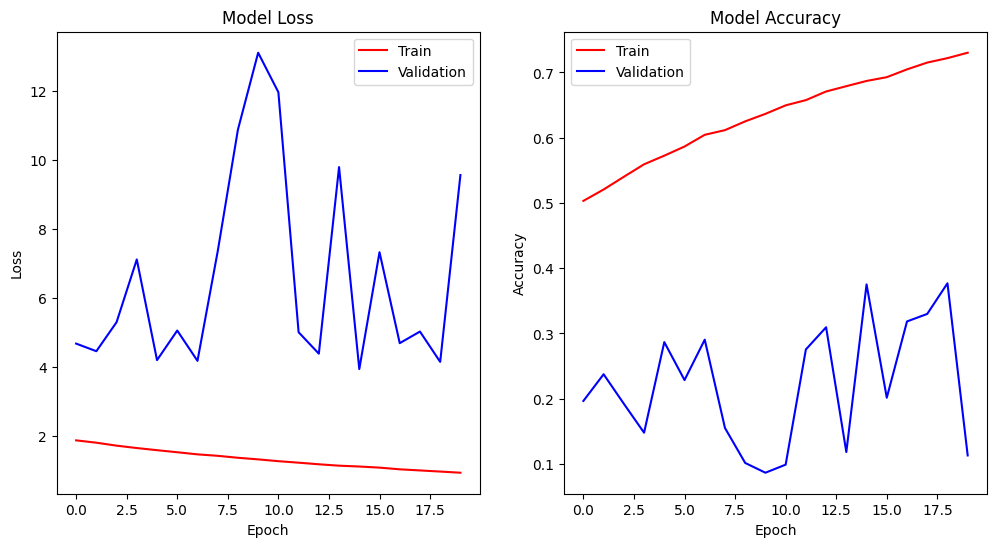

In [ ]:
# Step 2: Plot training & validation loss and accuracy
# Plot training & validation loss
plt.figure(figsize=(12, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Step 3: Predict the test data
# Use the test generator to get predictions
y_pred = model.predict(test_generator, steps=len(x_test) // batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted class indices

# Step 4: Prepare true labels
# If y_test is already in integer form, use it directly.
# If y_test is one-hot encoded, convert it to class indices.
# Uncomment the appropriate line based on your data format:
y_true = y_test  # If y_test is already in integer form
#y_true = np.array(y_test)  # Ensure y_test is in a NumPy array if it was a list

# If y_test is one-hot encoded, uncomment the next line:
# y_true = np.argmax(y_test, axis=1)

print(len(y_true), len(y_pred_classes))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Load the label-to-class index mapping from the JSON file
with open('label_to_class_index.json', 'r') as f:
    label_to_class_index = json.load(f)

# Print the loaded mapping to verify (optional)
# print(label_to_class_index)

# Prepare words for plotting confusion matrix
words = [label for label, index in label_to_class_index.items()]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=words, yticklabels=words)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step
3503 3471


ValueError: Found input variables with inconsistent numbers of samples: [3503, 3471]